# Introduzione

In questo notebook cerco di creare un modello per la classificazione delle carezze utilizzando come dataset un dataset contenente carezze, 'silenzio', letture randomiche.

Dubbi personali:
- Cambierebbe qualcosa nel non prendere letture randomiche o nel prenderne di più? 
- Lazypredict restituisce dei classificatori senza dire quali sono i parametri utilizzati. Come posso trovare quelli ottimali? GridSearch?

## Librerie

In [2]:
# Librerie generali per l'analisi dei dati
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import numpy as np


# Libreria TSFRESH per l'estrazione di features
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters  
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import settings

# Libreria LAZYPREDICT per la classificazione
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Librerie per la classificazione con normalizzazione
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Librerie per la classificazione e la valutazione dei risultati
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, jaccard_score

## Lettura dei dati

In [3]:
# Path to the dataset
path = 'C:/Users/miche/Desktop/Virtual Environment/zz - prove/csv_classificazione_carezze/'

## Funzioni

### Funzione di conversione del tempo da %H:%M:%S:%Frame a secondi

In [4]:
def convert_time_frame(time_str, frame_rate, shift_seconds):
    
    # Split the time string in hours, minutes, seconds and frames
    parts = time_str.split(':')
    
    # Calculate the total time in seconds: (hours:minutes:seconds:frames) - one hour + the shift
    total_seconds = (int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2]) + int(parts[3]) / frame_rate) - 3600 + shift_seconds

    return total_seconds

### Funzione per l'analisi dei dati e le creazioni delle labels

In [5]:
def labelling_custom(string, rate, shift_seconds):

    # Read the file csv with the values of the sensors
    df_sensor = pd.read_csv(path + string + '.csv', sep=',', header=0)


    # Read the file csv with the markers
    df_marker = pd.read_csv(path + string + '_marker.csv', sep=',', header=0)
    
    # Keep only the columns # (index) and Source In (istant of the marker)
    df_marker = df_marker[['#', 'Source In']]

    # Create a list of pairs of start and end values
    start_times = df_marker.loc[df_marker['#'] % 2 == 1, 'Source In']
    end_times = df_marker.loc[df_marker['#'] % 2 == 0, 'Source In']

    # Convert the time format
    start_times_seconds = start_times.apply(lambda x: convert_time_frame(x, rate, shift_seconds))
    end_times_seconds = end_times.apply(lambda x: convert_time_frame(x, rate, shift_seconds))

    return df_sensor, start_times_seconds, end_times_seconds

### Funzione per la creazione di un dataframe unico con la divisione delle labels fra 'Carezze' e 'No tocco'

In [6]:
def overall_custom(dataframe, string, starting_times, ending_times):
    df = dataframe.copy()
    df['Label'] = 'No tocco'
    df['name'] = string
    for start, end in zip(starting_times, ending_times):
        df.loc[(df['Time'] >= start) & (df['Time'] <= end), 'Label'] = 'Carezza'
    
    return df

### Funzione di creazione dei plot per la parte di analisi dei dati

In [7]:
def plot_custom(dataframe4value, time4start, time4time, slider):
    
    # Convert the dataframe in numpy arrays
    time = dataframe4value['Time'].to_numpy()
    flexsx = dataframe4value['Flexsx'].to_numpy()
    flexdx = dataframe4value['Flexdx'].to_numpy()
    pressure = dataframe4value['Pressure'].to_numpy()

    # Plot all the values with vertical lines that indicate the start and the end of the touch
    fig, axes = plt.subplots(3,1, figsize=(20,5))    
    axes[0].plot(time, flexsx)
    axes[1].plot(time, flexdx)
    axes[2].plot(time, pressure)
    
    for start, end in zip(time4start, time4time):
        if start < time[-1]:
            axes[0].axvspan(start, end, color='red', alpha=0.5)
            axes[1].axvspan(start, end, color='red', alpha=0.5)

    # Plot only 1000 values with vertical lines that indicate the start and the end of the touch
    fig, axes = plt.subplots(3,1, figsize=(20,5))
    axes[0].plot(time[1000*slider:1000*(slider+1)], flexsx[1000*slider:1000*(slider+1)])
    axes[1].plot(time[1000*slider:1000*(slider+1)], flexdx[:1000])
    axes[2].plot(time[1000*slider:1000*(slider+1)], pressure[1000*slider:1000*(slider+1)])
    # Plotta le fasce verticali
    for start, end in zip(time4start, time4time):
        if start < time[1000*(slider+1)] and start > time[1000*slider]: 
            axes[0].axvspan(start, end, color='red', alpha=0.5)
            axes[1].axvspan(start, end, color='red', alpha=0.5)
            axes[2].axvspan(start, end, color='red', alpha=0.5)

## Creazione del dataframe complessivo

In [8]:
df_overall = pd.DataFrame()

# Labelling delle carezze

## Carezze varie

### Michele dx

In [9]:
filename = 'michele_varie'
shift = -2.2
frame_rate = 30
slider = 0

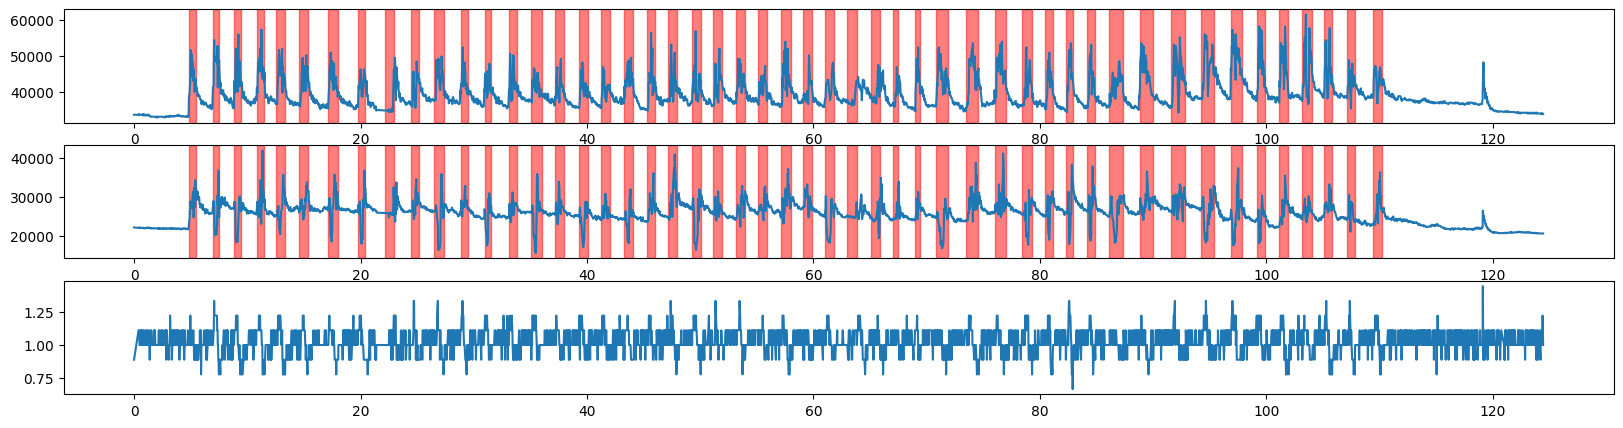

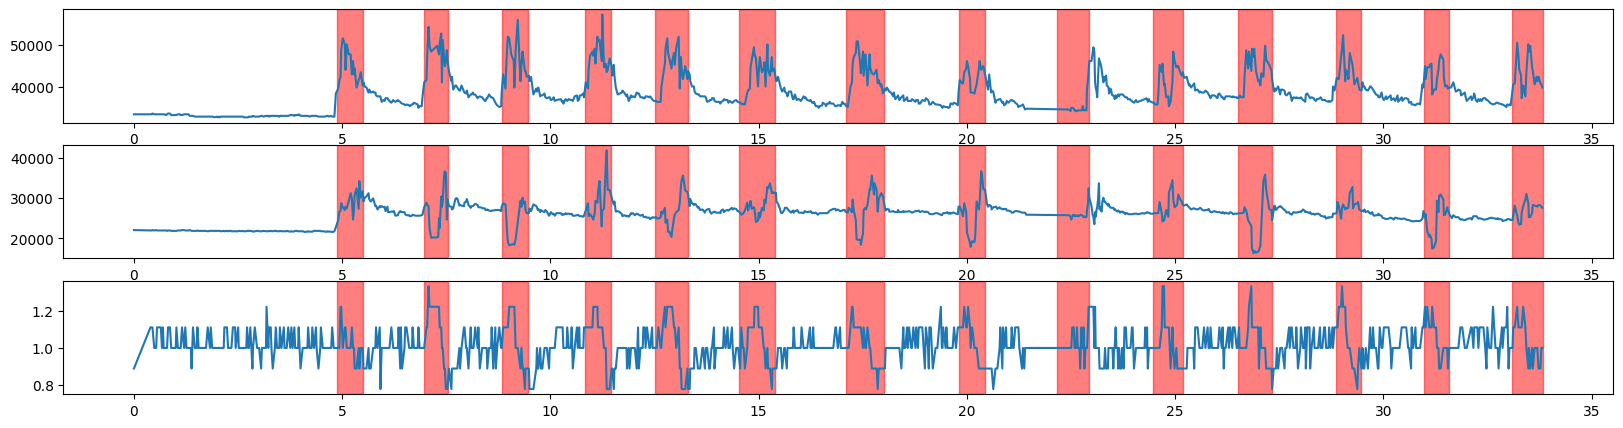

In [10]:
# Label the dataframe
df1, start_time1, end_times1 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df1, start_time1, end_times1, slider)

# Add the label to the dataframe
label_df1 = overall_custom(df1, filename, start_time1, end_times1)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df1], ignore_index=True)

### Michele sx

In [11]:
filename = 'michele_variesx'
shift = -2.4
frame_rate = 29.97
slider = 0

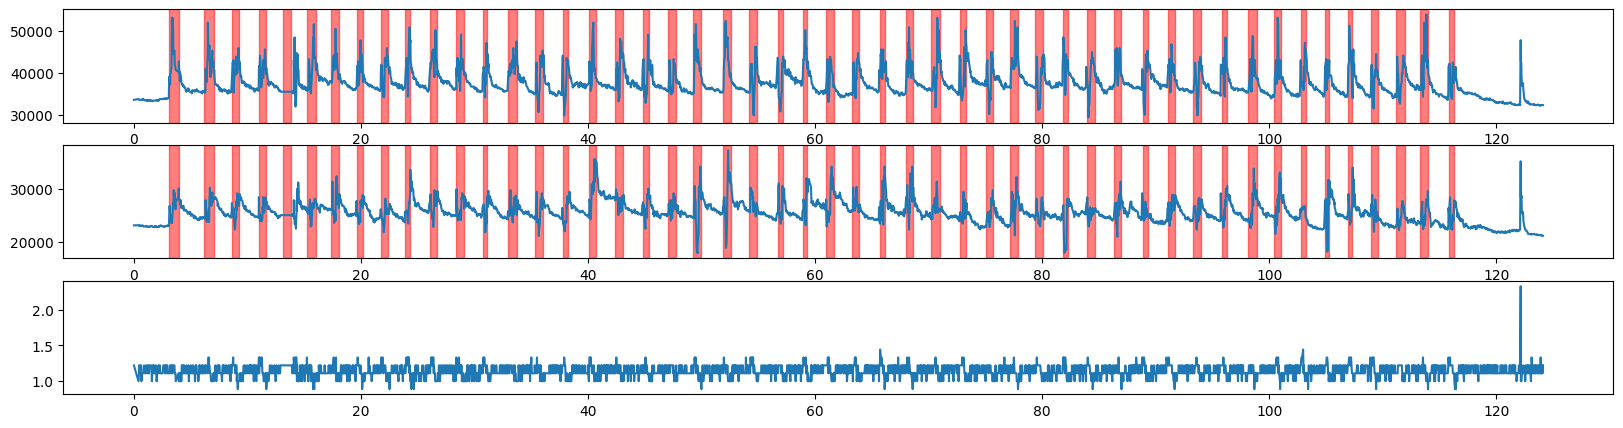

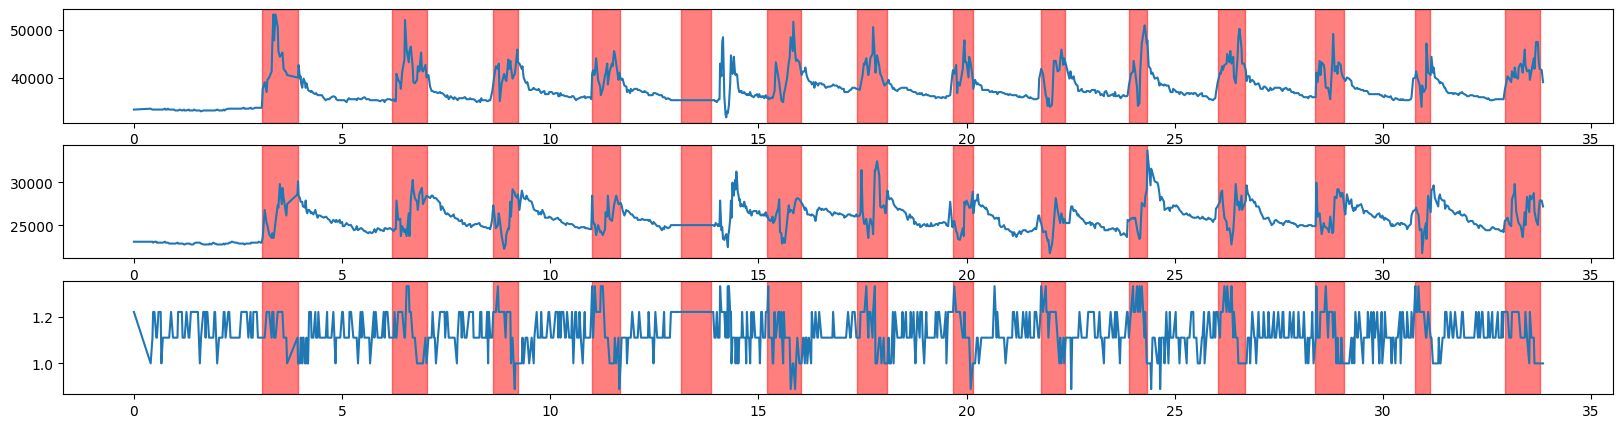

In [12]:
# Label the dataframe
df2, start_time2, end_times2 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df2, start_time2, end_times2, slider)

# Add the label to the dataframe
label_df2 = overall_custom(df2, filename, start_time2, end_times2)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df2], ignore_index=True)

### Massimiliano sx

In [13]:
filename = 'massimiliano_varie'
shift = - 7.6
frame_rate = 29.97
slider = 0

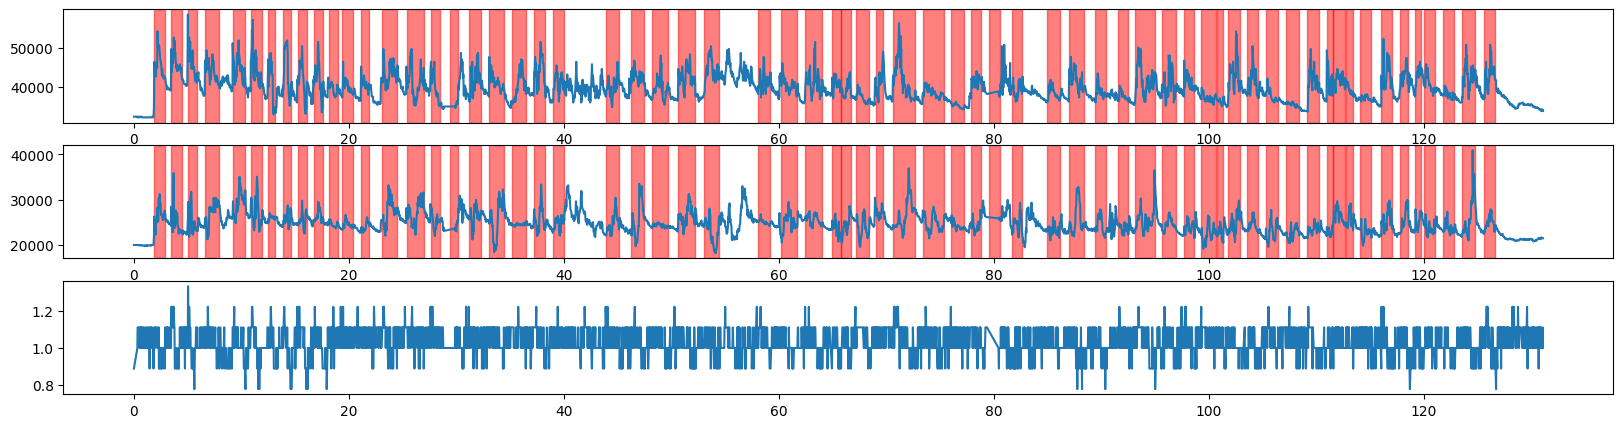

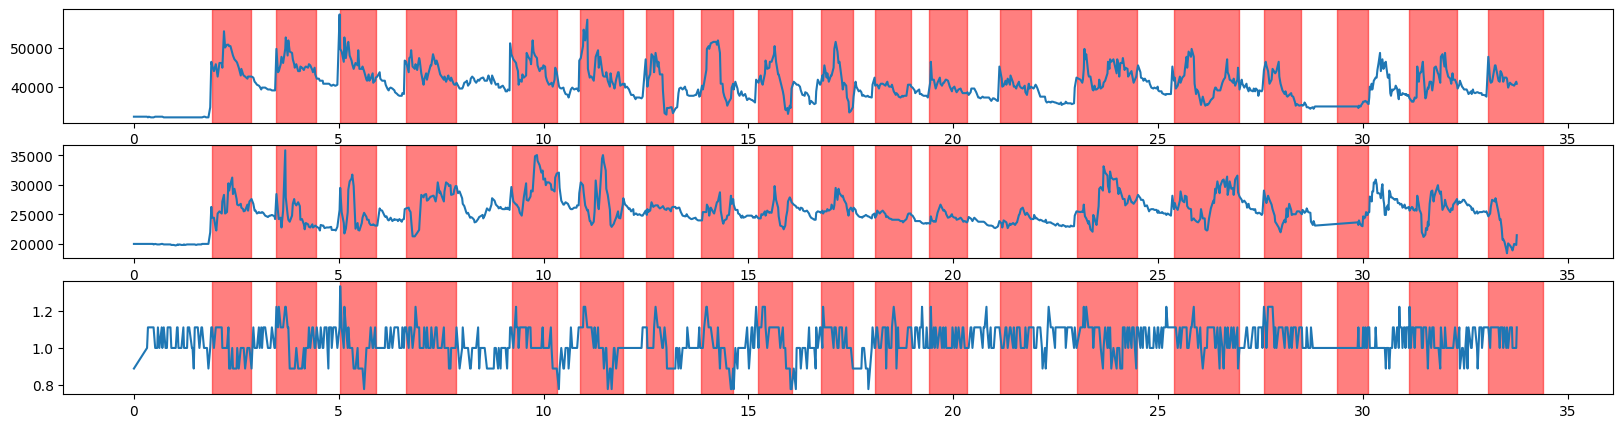

In [14]:
# Label the dataframe
df3, start_time3, end_times3 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df3, start_time3, end_times3, slider)

# Add the label to the dataframe
label_df3 = overall_custom(df3, filename, start_time3, end_times3)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df3], ignore_index=True)

### Massimiliano dx

In [15]:
filename = 'massimiliano_variedx'
shift = - 1.85
frame_rate = 29.97
slider = 0

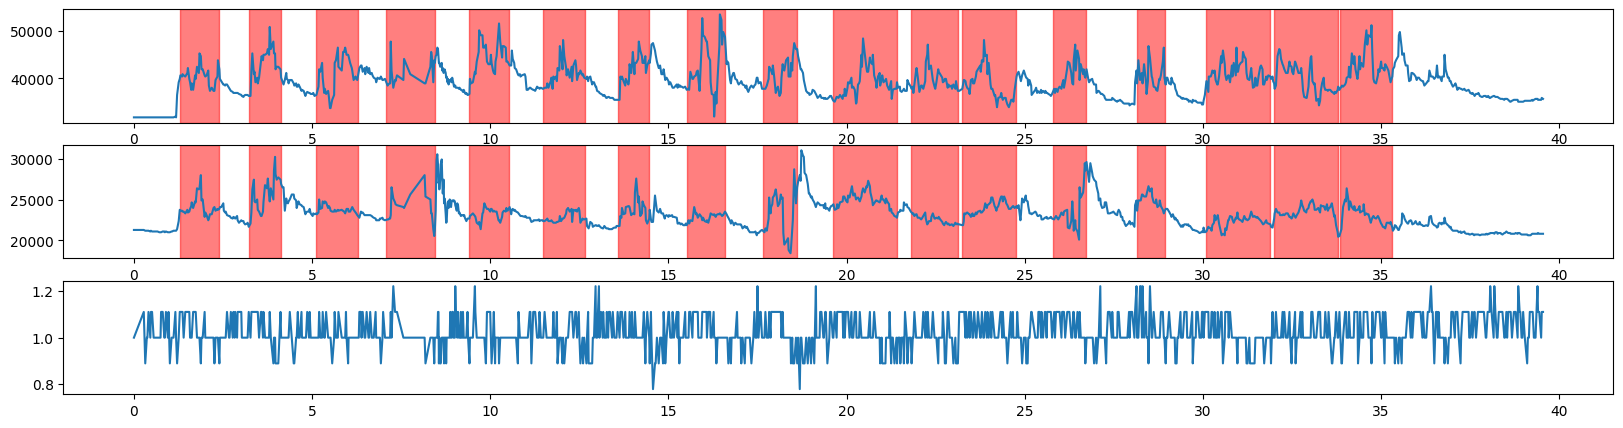

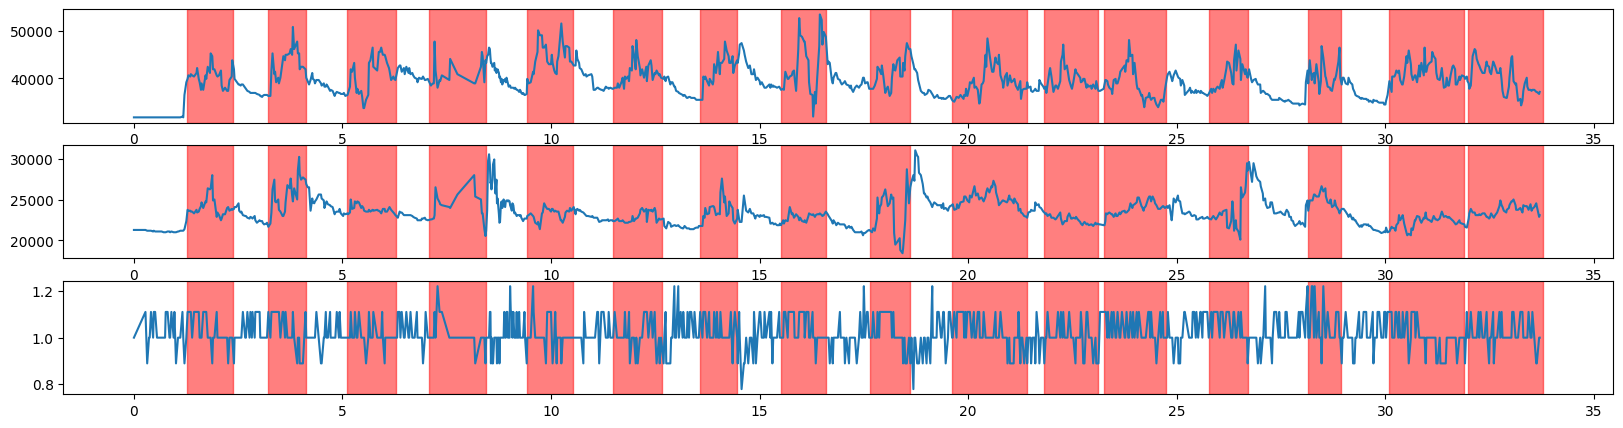

In [16]:
# Label the dataframe
df4, start_time4, end_times4 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df4, start_time4, end_times4, slider)

# Add the label to the dataframe
label_df4 = overall_custom(df4, filename, start_time4, end_times4)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df4], ignore_index=True)

### Virginia varie

In [17]:
filename = 'virginia_varie'
shift = - 1.55
frame_rate = 24
slider = 0

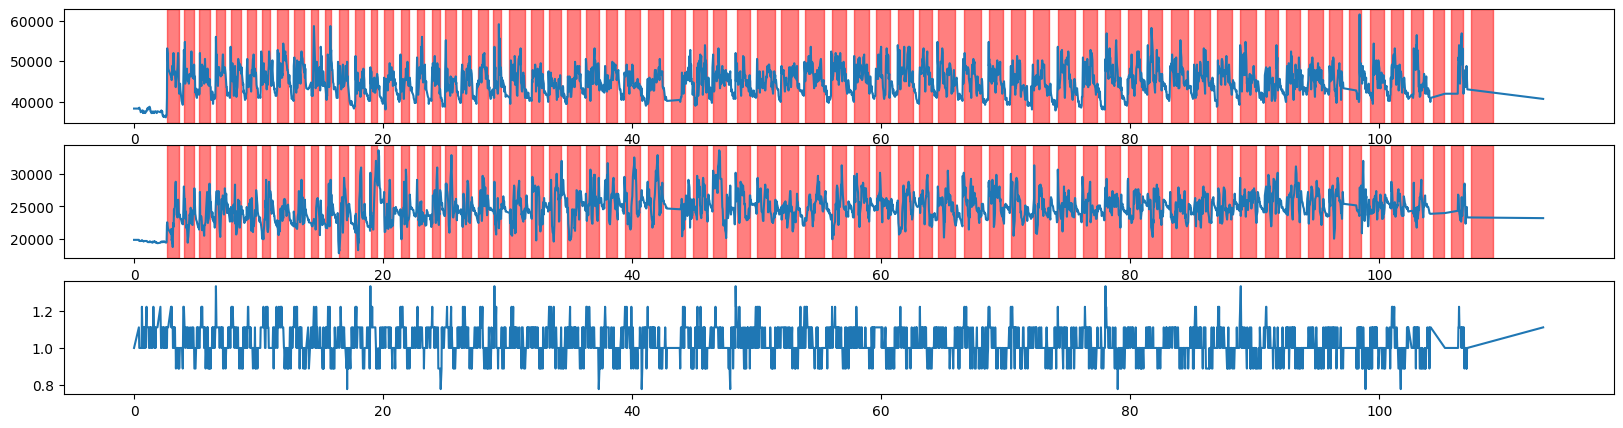

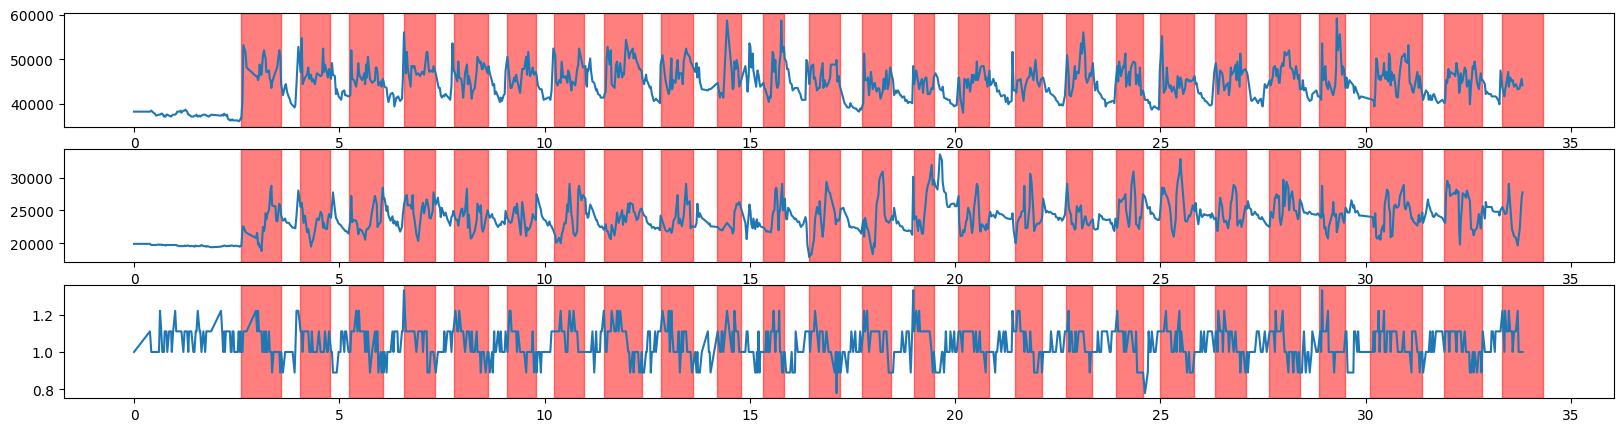

In [18]:
# Label the dataframe
df5, start_time5, end_times5 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df5, start_time5, end_times5, slider)

# Add the label to the dataframe
label_df5 = overall_custom(df5, filename, start_time5, end_times5)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df5], ignore_index=True)

### Gianluca varie

In [19]:
filename = 'gianluca_varie'
shift = - 4.35
frame_rate = 30
slider = 0

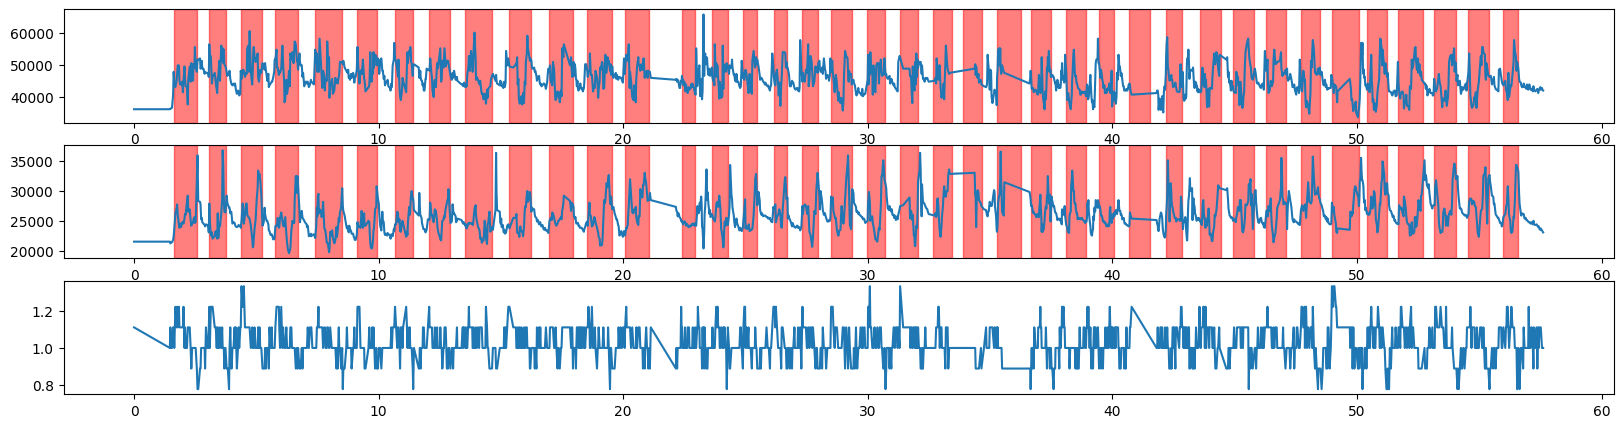

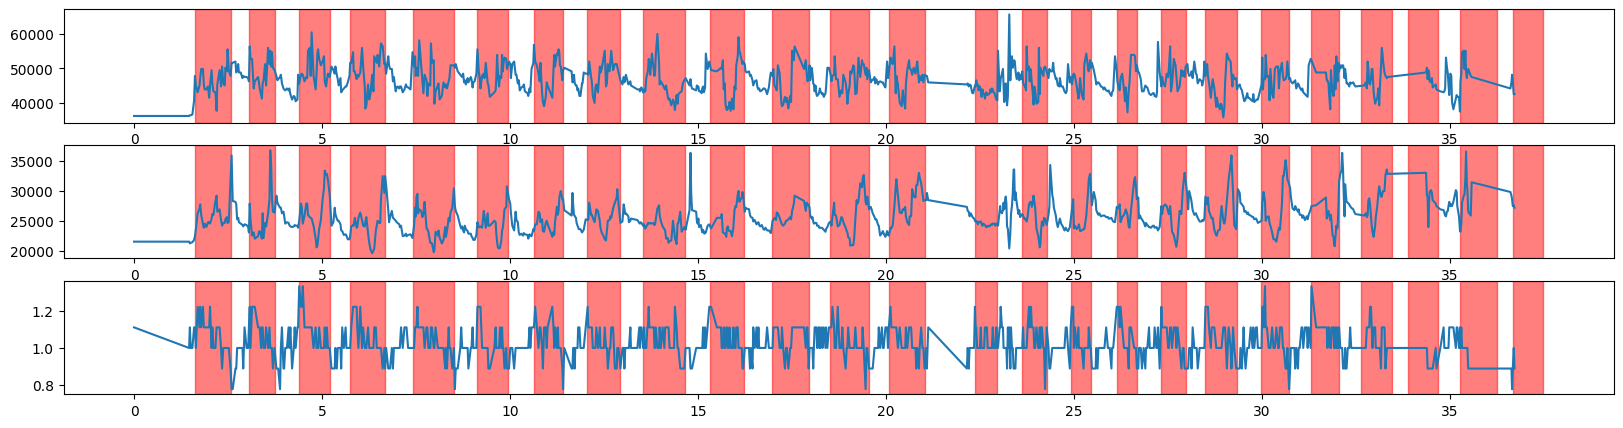

In [20]:
# Label the dataframe
df6, start_time6, end_times6 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df6, start_time6, end_times6, slider)

# Add the label to the dataframe
label_df6 = overall_custom(df6, filename, start_time6, end_times6)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df6], ignore_index=True)

### Lorenzo varie

In [21]:
filename = 'lorenzo_varie'
shift = - 2.5
frame_rate = 30
slider = 0

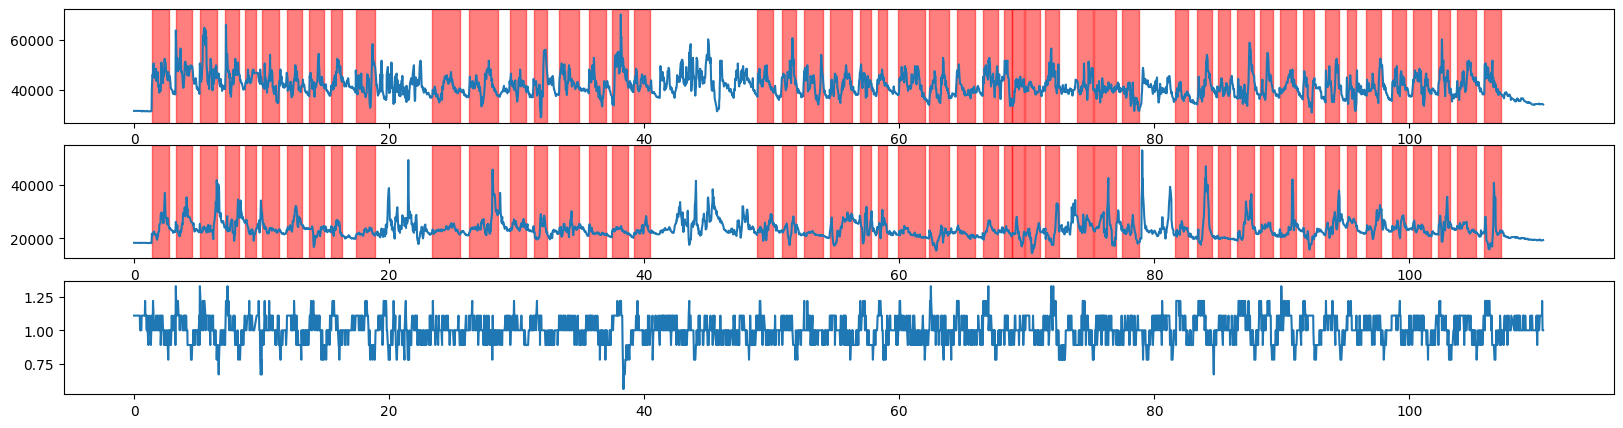

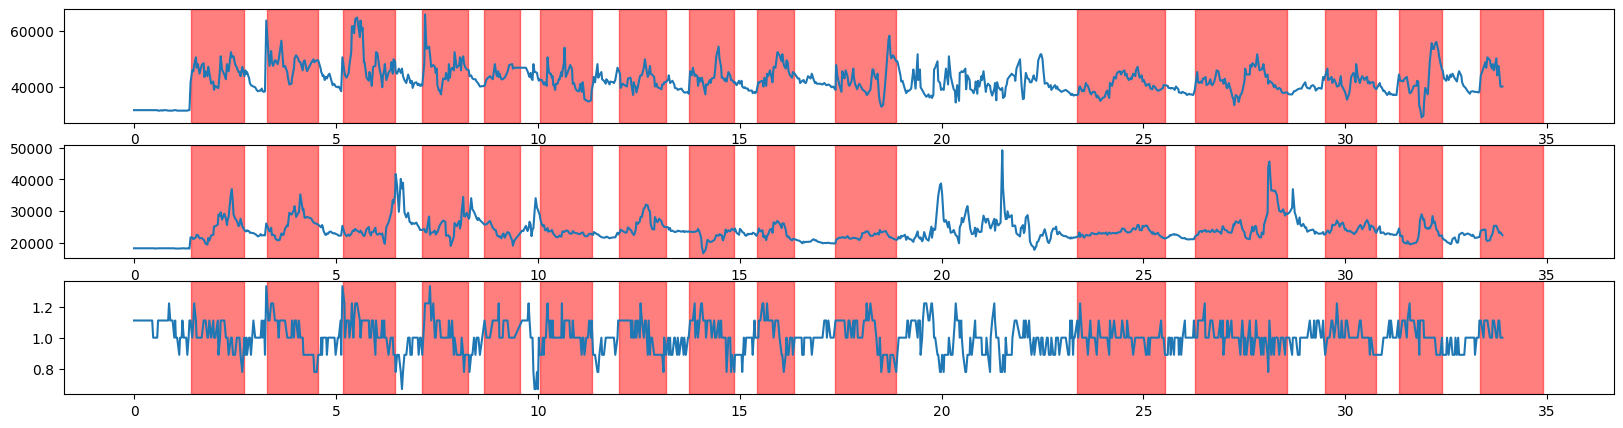

In [22]:
# Label the dataframe
df7, start_time7, end_times7 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df7, start_time7, end_times7, slider)

# Add the label to the dataframe
label_df7 = overall_custom(df7, filename, start_time7, end_times7)

# Add the dataframe to the overall dataframe
df_overall = pd.concat([df_overall, label_df7], ignore_index=True)

## Pot di tutti i dataframe analizzati fin'ora

In [23]:
for id in df_overall['name'].unique():
    df_overall[df_overall['name'] == id].plot(x='Time', y=['Flexsx', 'Flexdx'], figsize=(20,2), title=id, grid=True, color=['blue', 'black'])
    for label, start, end in zip(df_overall[df_overall['name'] == id]['Label'], df_overall[df_overall['name'] == id]['Time'], df_overall[df_overall['name'] == id]['Time']):
        if label == 'Carezza':
            plt.axvspan(start, end, color='orange', alpha=0.5)
    plt.close()

## Carezze trasversali - TO CHECK

### Michele trasversali

In [24]:
filename = 'michele_trasversali'
shift = - 1.55
frame_rate = 24
slider = 0

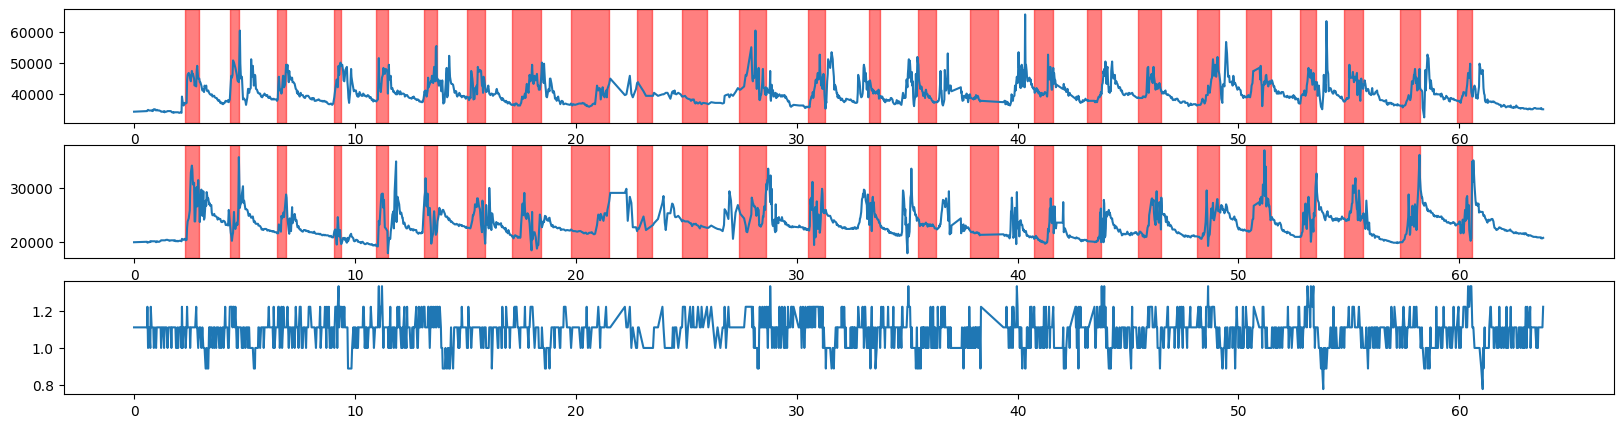

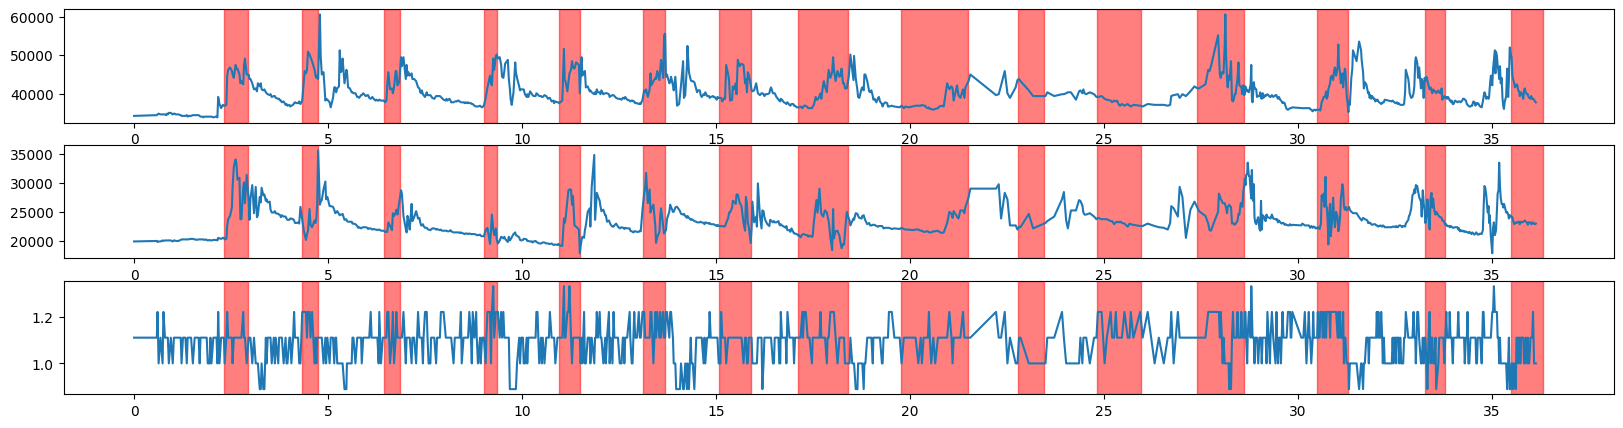

In [25]:
# Label the dataframe
df8, start_time8, end_times8 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df8, start_time8, end_times8, slider)

### Massimiliano trasversali

In [26]:
filename = 'massimiliano_trasversali'
shift = - 2.
frame_rate = 30
slider = 0

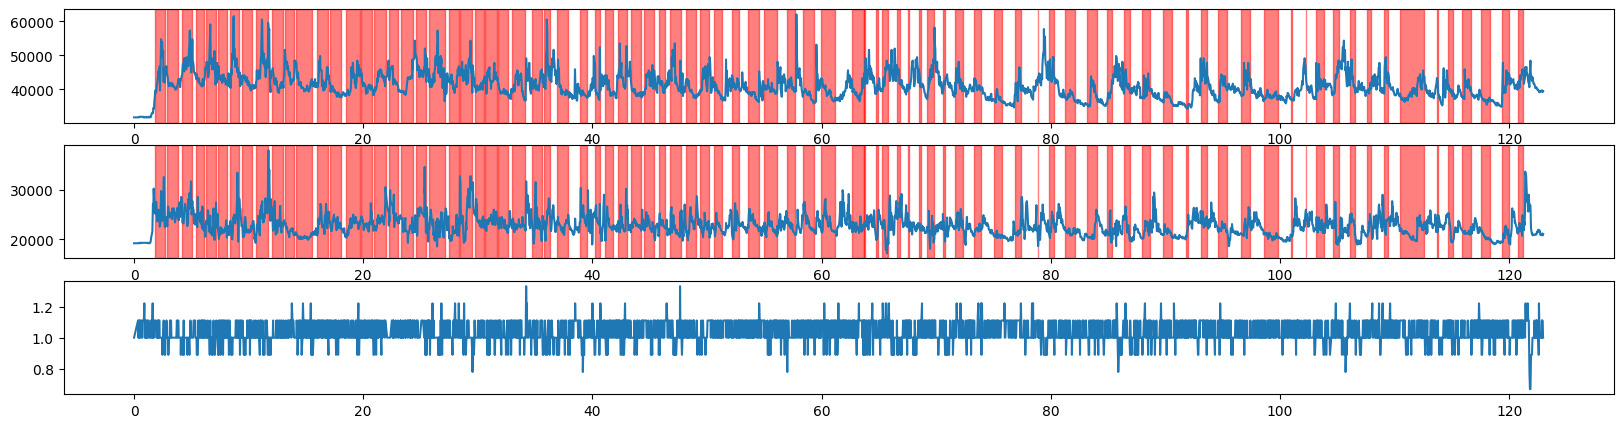

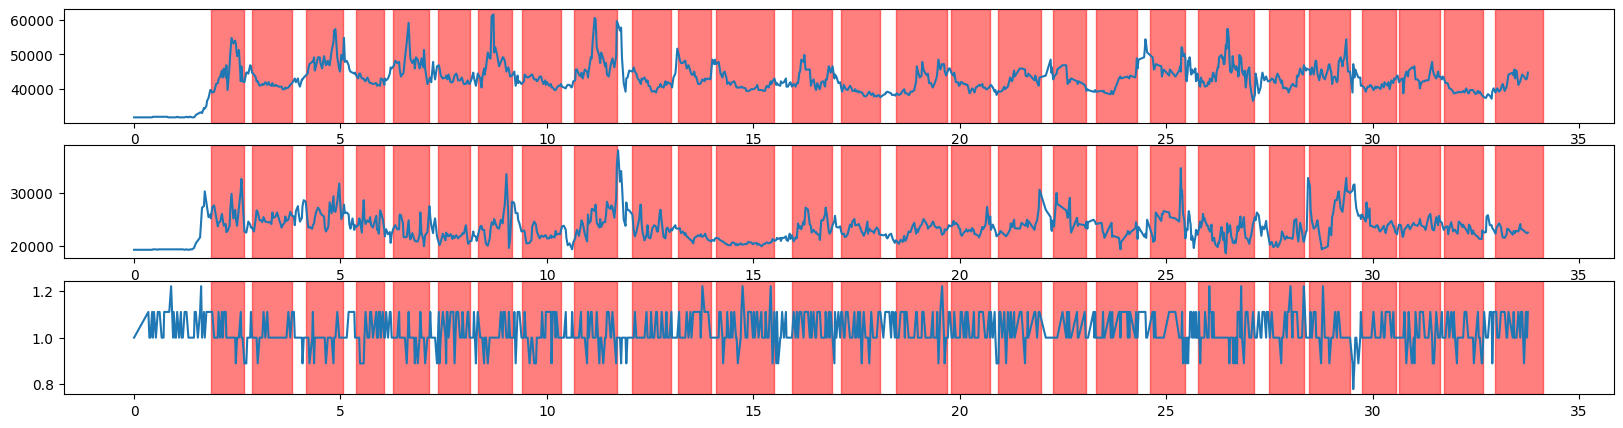

In [27]:
# Label the dataframe
df9, start_time9, end_times9 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df9, start_time9, end_times9, slider)

### Gianluca trasversali

In [28]:
filename = 'gianluca_trasversali'
shift = - 1.4
frame_rate = 29.97
slider = 0

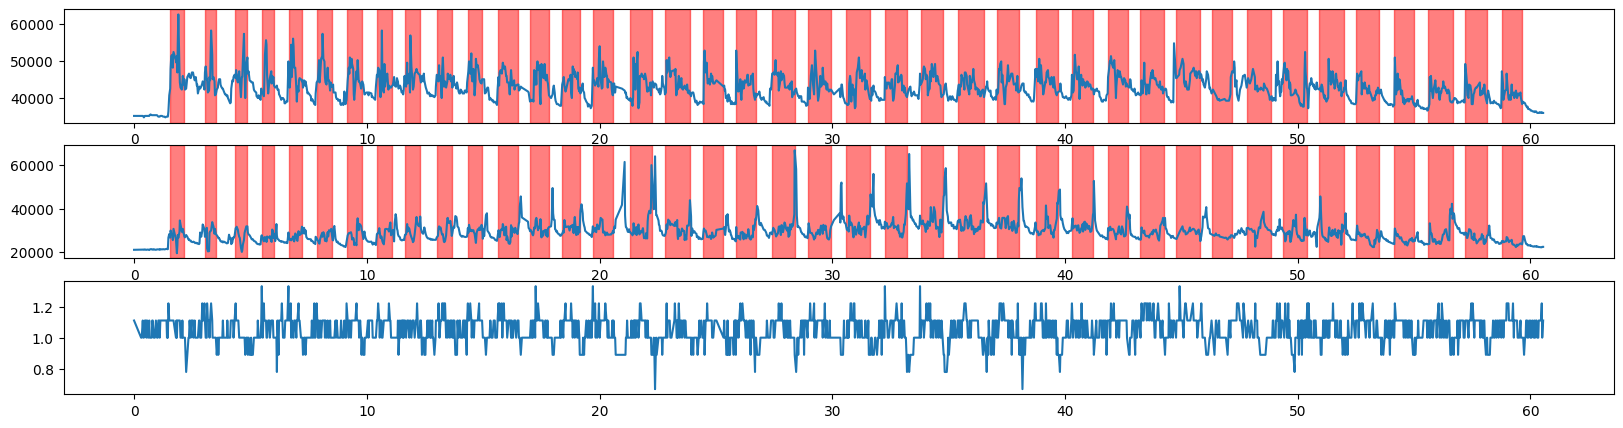

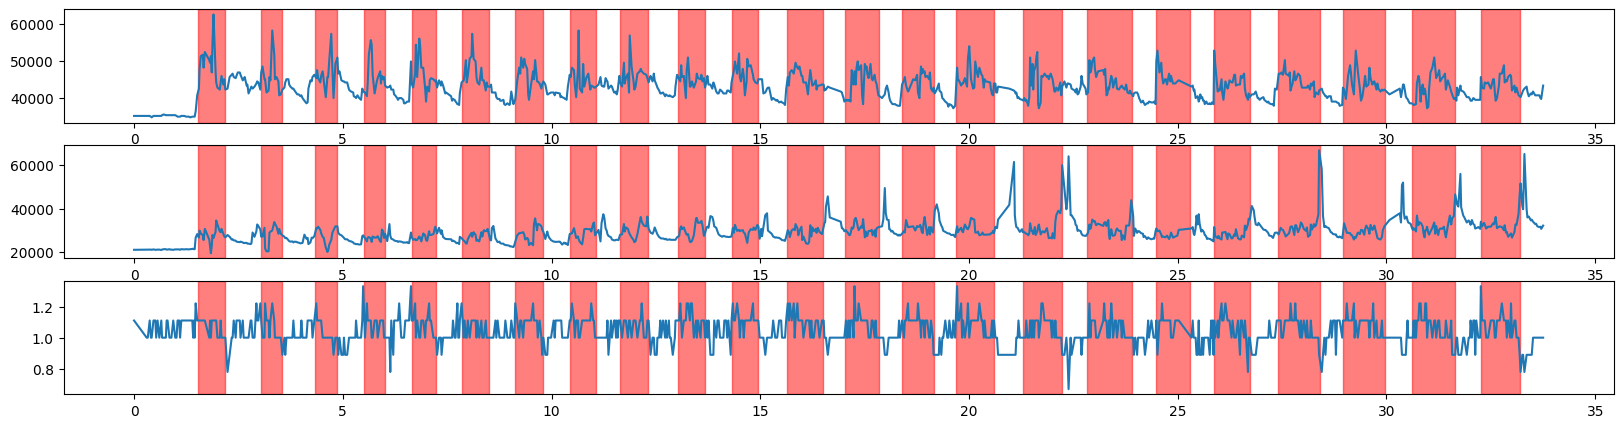

In [29]:
# Label the dataframe
df10, start_time10, end_times10 = labelling_custom(filename, frame_rate, shift)

# Plot the dataframe
plot_custom(df10, start_time10, end_times10, slider)

# Estrazione con vari tipi di segnale

## Carezze

### Dati delle carezze

In [30]:
df_data = df_overall.copy()

# Add the id column
df_data['id'] = 0

# The ids will start from 1
ids = 1

for index,label in enumerate(df_data['Label']):
    try:
        if df_overall['Label'][index] is not df_data['Label'][index-1]:
            ids += 1
        elif df_overall['name'][index] is not df_data['name'][index-1]:
            ids += 1
    except:
        pass
    df_data['id'][index] = ids

# Drop the columns 'Label' and 'name'
data = df_data[['Time','Flexsx', 'Flexdx', 'Pressure', 'id']]

# Print the size of the variables taken into account
print('Size of the dataset: ', data.shape)
print('Number of ids: ', data['id'].nunique())

Size of the dataset:  (20570, 5)
Number of ids:  671


In [31]:
# Initialize the target array
target = []

for i in df_data['id'].unique():
    
    # If the label of the ids is 'Carezza'
    if (df_data.loc[df_data['id'] == i, 'Label'] == 'Carezza').any():
        target.append(False)
    
    # If the label of the ids is 'No tocco'
    else:
        target.append(True)

# Convert the target array in a Pandas Series
target_serie = pd.Series(target, index = range(1, len(target) + 1))

# Print the target array size
print('Size of the target array: ', target_serie.shape)

Size of the target array:  (671,)


## Tocchi vari

### Metodo 1

In [32]:
path_altro = 'C:/Users/miche/Desktop/Virtual Environment/zz - prove/csv_classificazione_altro/'

In [33]:
# read all the file .csv in the folder and append them to the dataframe
df_tocchi_vari = pd.DataFrame()

for filename in os.listdir(path_altro):
    if filename.endswith('.csv'):
        file_path = os.path.join(path_altro, filename)
        df = pd.read_csv(file_path)
        df_tocchi_vari = pd.concat([df_tocchi_vari, df], ignore_index=True)

df_tocchi_vari['Label'] = 'No tocco'

# Print the size of the dataframe
print('Size of the dataframe: ', df_tocchi_vari.shape)

Size of the dataframe:  (16442, 6)


In [34]:
# Set random seed for reproducibility
np.random.seed()

# Create a copy of the dataframe
df_altro = df_tocchi_vari.copy()

# Initialize the id as the higher value of data_carezze['id'] + 1
id_max = data['id'].max() + 1

# Create some random groups of data
max_group_len = 100 # Maximum length of a group

num_groups = int(np.floor(len(df_altro) / max_group_len)) # Calculate the number of groups needed

group_lengths = np.random.randint(10, max_group_len + 1, size=num_groups) # Assign random lengths to each group

# Give to each group a crescent id
for index,value in enumerate(group_lengths):
    df_altro.loc[sum(group_lengths[:index]):sum(group_lengths[:index+1]), 'id'] = id_max
    id_max += 1


# Eliminate the data not selected in the previous step
df_altro = df_altro.dropna(subset=['id'])

# Convert the column id from float to int
df_altro['id'] = df_altro['id'].astype(int)

# Print the size of the dataframe
print('I decided to create ', num_groups, ' groups of data with a maximum length of ', max_group_len, ' values. The number of groups of data id due to the random choice of the length of each group.')
print('The real size of the data used is ', df_altro.shape)

I decided to create  164  groups of data with a maximum length of  100  values. The number of groups of data id due to the random choice of the length of each group.
The real size of the data used is  (9284, 7)


In [35]:
data_altro = df_altro[['Time', 'Flexsx', 'Flexdx', 'Pressure', 'id']]
target_altro = [True] * data_altro['id'].nunique()

target_series_altro = pd.Series(target_altro, index=range(1, len(target_altro) + 1))

In [36]:
# Print the size of the variables taken into account
print('Size of the dataset: ', data_altro.shape)
print('Number of ids: ', data_altro['id'].nunique())

print('Size of the target array: ', target_series_altro.shape)

Size of the dataset:  (9284, 5)
Number of ids:  164
Size of the target array:  (164,)


### Metodo 2

In [37]:
# Divide the dataframe in n parts of random lenght between 10 and 100 index and give them a id in order
np.random.seed(69)

# Copy of the dataframe
df_copy = df_tocchi_vari.copy()
df_altro_2 = df_tocchi_vari.copy()

# Maximum length of a group
max_group_len = 100

# Inizialize the id as the higher value of data['id'] + 1
id_max = data['id'].max() + 1

# The number of groups needed
num_groups = int(np.ceil(len(df_copy) / max_group_len))

# Distribuite the values of the dataframe in n groups of random length between 10 and 100
while len(df_copy) > 0:
    # The length of the next group is a random number between 10 and 100
    group_length = np.random.randint(10, max_group_len + 1)
    
    # Check if the length of the next group is higher than the length of the dataframe
    group_length = min(group_length, len(df_copy))
    
    # Assign the same id to all the rows of the group
    indices_list = df_copy.index[:group_length].tolist()
    df_altro_2.loc[indices_list, 'id'] = id_max
    id_max += 1

    # Delete the rows of the group from the dataframe
    df_copy = df_copy.iloc[group_length:]

# Eliminate the data not selected in the previous step
df_altro_2 = df_altro_2.dropna(subset=['id'])

# Convert the column id from float to int
df_altro_2['id'] = df_altro_2['id'].astype(int)

# Print the dimension of each group
print(tabulate((df_altro_2.groupby('id').size()).reset_index(name='group_size'), headers='keys', tablefmt='psql'))

+-----+------+--------------+
|     |   id |   group_size |
|-----+------+--------------|
|   0 |  672 |           64 |
|   1 |  673 |           85 |
|   2 |  674 |           83 |
|   3 |  675 |          100 |
|   4 |  676 |           65 |
|   5 |  677 |           30 |
|   6 |  678 |           59 |
|   7 |  679 |           32 |
|   8 |  680 |           19 |
|   9 |  681 |           66 |
|  10 |  682 |           48 |
|  11 |  683 |           98 |
|  12 |  684 |           22 |
|  13 |  685 |           47 |
|  14 |  686 |           85 |
|  15 |  687 |           63 |
|  16 |  688 |           13 |
|  17 |  689 |           90 |
|  18 |  690 |           49 |
|  19 |  691 |           34 |
|  20 |  692 |           12 |
|  21 |  693 |           49 |
|  22 |  694 |           34 |
|  23 |  695 |           57 |
|  24 |  696 |          100 |
|  25 |  697 |           85 |
|  26 |  698 |           54 |
|  27 |  699 |           33 |
|  28 |  700 |           45 |
|  29 |  701 |           53 |
|  30 |  7

In [38]:
data_altro_2 = df_altro_2[['Time', 'Flexsx', 'Flexdx', 'Pressure', 'id']]
target_altro_2 = [True] * df_altro_2['id'].nunique()

target_series_altro_2 = pd.Series(target_altro_2, index=range(1, len(target_altro_2) + 1))

In [39]:
# Print the size of the variables taken into account
print('Size of the dataset: ', data_altro_2.shape)
print('Number of ids: ', data_altro_2['id'].nunique())

print('Size of the target array: ', target_series_altro_2.shape)

Size of the dataset:  (16442, 5)
Number of ids:  303
Size of the target array:  (303,)


## Concatenazione dei dati

In [40]:
data_all = pd.concat([data, data_altro], ignore_index=True)
target_all = pd.concat([target_serie, target_series_altro], ignore_index=True)
target_all.index = target_all.index + 1 # Shift the index of one position. The index starts from 1 as the ids

data_all_2 = pd.concat([data, data_altro_2], ignore_index=True)
target_all_2 = pd.concat([target_serie, target_series_altro_2], ignore_index=True)
target_all_2.index = target_all_2.index + 1 # Shift the index of one position. The index starts from 1 as the ids

In [41]:
print("First method:")
print("Size of the dataset: ", data_all.shape)
print("Size of the target array: ", target_all.shape)
print("Number of ids: ", data_all['id'].nunique())
print("Number of True: ", target_all.sum())
print("Number of False: ", len(target_all) - target_all.sum())

print("")

print("Second method:")
print("Size of the dataset: ", data_all_2.shape)
print("Size of the target array: ", target_all_2.shape)
print("Number of ids: ", data_all_2['id'].nunique())
print("Number of True: ", target_all_2.sum())
print("Number of False: ", len(target_all_2) - target_all_2.sum())

First method:
Size of the dataset:  (29854, 5)
Size of the target array:  (835,)
Number of ids:  835
Number of True:  503
Number of False:  332

Second method:
Size of the dataset:  (37012, 5)
Size of the target array:  (974,)
Number of ids:  974
Number of True:  642
Number of False:  332


# Estrazione delle features

## Metodo minima + kind

In [42]:
# Extract the features
features_minima = extract_features(data_all, column_id='id', column_sort='Time', default_fc_parameters=MinimalFCParameters())
features_minima_2 = extract_features(data_all_2, column_id='id', column_sort='Time', default_fc_parameters=MinimalFCParameters())

# Impute the missing values
impute(features_minima)
impute(features_minima_2)

# Select the relevant features
features_filtered = select_features(features_minima, target_all)
features_filtered_2 = select_features(features_minima_2, target_all_2)

Feature Extraction:   0%|          | 0/30 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]


In [43]:
print('The number of features before and after the selection for the I method are respectively {} and {}'.format(features_minima.shape[1], features_filtered.shape[1]))
print('The number of features before and after the selection for the II method are respectively {} and {}'.format(features_minima_2.shape[1], features_filtered_2.shape[1]))

The number of features before and after the selection for the I method are respectively 30 and 21
The number of features before and after the selection for the II method are respectively 30 and 23


In [44]:
# Kind of features
kind_all = settings.from_columns(features_filtered)

# Print the kind of features
print('Kind of features for the I method: ')
print(tabulate(kind_all, headers='keys', tablefmt='psql'))

# Kind of features
kind_all_2 = settings.from_columns(features_filtered_2)

# Print the kind of features
print('Kind of features for the II method: ')
print(tabulate(kind_all_2, headers='keys', tablefmt='psql'))

Kind of features for the I method: 
+--------------------+--------------------+--------------------+
| Flexsx             | Flexdx             | Pressure           |
|--------------------+--------------------+--------------------|
| median             | variance           | standard_deviation |
| root_mean_square   | standard_deviation | variance           |
| mean               | median             | length             |
| standard_deviation | root_mean_square   |                    |
| variance           | mean               |                    |
| absolute_maximum   | absolute_maximum   |                    |
| maximum            | maximum            |                    |
| length             | minimum            |                    |
| minimum            | length             |                    |
+--------------------+--------------------+--------------------+
Kind of features for the II method: 
+--------------------+--------------------+--------------------+
| Flexsx         

## Classificazione con Lazypredict

### Kind method

In [45]:
# Extract the features
features_all = extract_features(data_all, column_id='id', column_sort='Time', kind_to_fc_parameters=kind_all)
features_all_2 = extract_features(data_all_2, column_id='id', column_sort='Time', kind_to_fc_parameters=kind_all_2)

Feature Extraction:   0%|          | 0/30 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 30/30 [00:03<00:00,  9.39it/s]


In [46]:
%%capture
# Classify the data with the I method

# Data
X_all = features_all.values
y_all = target_all

# Split the data in train and test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Initialize the classifier
clf_all = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Train the classifier
models_all, predictions_all = clf_all.fit(X_train_all, X_test_all, y_train_all, y_test_all)

In [47]:
print("The results for the classification are: ")
print(tabulate(models_all, headers='keys', tablefmt='psql'))

The results for the classification are: 
+-------------------------------+------------+---------------------+-----------+------------+--------------+
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   Time Taken |
|-------------------------------+------------+---------------------+-----------+------------+--------------|
| SVC                           |   0.904192 |            0.904827 |  0.904827 |   0.904664 |    0.0285509 |
| RandomForestClassifier        |   0.898204 |            0.902715 |  0.902715 |   0.898996 |    0.353226  |
| LGBMClassifier                |   0.904192 |            0.899246 |  0.899246 |   0.904192 |    0.234678  |
| XGBClassifier                 |   0.886228 |            0.88733  |  0.88733  |   0.886905 |    0.133934  |
| LinearSVC                     |   0.886228 |            0.88733  |  0.88733  |   0.886905 |    0.0454247 |
| CalibratedClassifierCV        |   0.886228 |            0.88733  |  0.88733  |   0.88

In [48]:
%%capture
# Classify the data with the II method

# Data
X_all = features_all_2.values
y_all = target_all_2

# Split the data in train and test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Initialize the classifier
clf_all = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Train the classifier
models_all_2, predictions_all = clf_all.fit(X_train_all, X_test_all, y_train_all, y_test_all)


In [49]:
print("The results for the classification are: ")
print(tabulate(models_all_2, headers='keys', tablefmt='psql'))

The results for the classification are: 
+-------------------------------+------------+---------------------+-----------+------------+--------------+
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   Time Taken |
|-------------------------------+------------+---------------------+-----------+------------+--------------|
| ExtraTreesClassifier          |   0.876923 |            0.869231 |  0.869231 |   0.877799 |    0.169904  |
| XGBClassifier                 |   0.85641  |            0.85     |  0.85     |   0.857882 |    0.105222  |
| RandomForestClassifier        |   0.866667 |            0.85     |  0.85     |   0.866667 |    0.344217  |
| SVC                           |   0.871795 |            0.842308 |  0.842308 |   0.869827 |    0.0332949 |
| LabelSpreading                |   0.841026 |            0.834615 |  0.834615 |   0.842888 |    0.0542805 |
| LabelPropagation              |   0.841026 |            0.834615 |  0.834615 |   0.84

## Modelli

In [50]:
# Data
X_all = features_all.values
X_all_2 = features_all_2.values

y_all = target_all
y_all_2 = target_all_2

# Split the data in train and test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train_all_2, X_test_all_2, y_train_all_2, y_test_all_2 = train_test_split(X_all_2, y_all_2, test_size=0.2, random_state=42)

# Initialize the classifier for the I method
clf_all_etc = ExtraTreeClassifier(random_state=0)
clf_all_knn = KNeighborsClassifier()

# Train the classifier for the I method
clf_all_etc.fit(X_train_all, y_train_all)
clf_all_knn.fit(X_train_all, y_train_all)

# Predict the test set for the I method
y_pred_all_cccv = clf_all_etc.predict(X_test_all)
y_pred_all_svc = clf_all_knn.predict(X_test_all)

# Initialize the classifier for the II method
clf_all_knn_2 = KNeighborsClassifier()
clf_all_svc_2 = SVC(random_state=0, tol=1e-5, max_iter=10000)
clf_all_rfc_2 = RandomForestClassifier(random_state=0)

clf_all_etsc_2 = ExtraTreesClassifier(random_state=0)

# Train the classifier for the II method
clf_all_knn_2.fit(X_train_all_2, y_train_all_2)
clf_all_svc_2.fit(X_train_all_2, y_train_all_2)
clf_all_rfc_2.fit(X_train_all_2, y_train_all_2)

clf_all_etsc_2.fit(X_train_all_2, y_train_all_2)

# Predict the test set for the II method
y_pred_all_knn_2 = clf_all_knn_2.predict(X_test_all_2)
y_pred_all_svc_2 = clf_all_svc_2.predict(X_test_all_2)
y_pred_all_rfc_2 = clf_all_rfc_2.predict(X_test_all_2)

y_pred_all_etsc_2 = clf_all_etsc_2.predict(X_test_all_2)

In [51]:
# Print the results

print("")
print("----- I method -----")
print("")


print('Classification report for ExtraTreeClassifier')
print(classification_report(y_test_all, y_pred_all_cccv))
print('F1 score for ExtraTreeClassifier: ', f1_score(y_test_all, y_pred_all_cccv))
print('Jaccard score for ExtraTreeClassifier: ', jaccard_score(y_test_all, y_pred_all_cccv))
print("")
print('Classification report for KNeighborsClassifier')
print(classification_report(y_test_all, y_pred_all_svc))
print('F1 score for KNeighborsClassifier: ', f1_score(y_test_all, y_pred_all_svc))
print('Jaccard score for KNeighborsClassifier: ', jaccard_score(y_test_all, y_pred_all_svc))

print("")
print("----- II method -----")
print("")

print('Classification report for KNeighborsClassifier')
print(classification_report(y_test_all_2, y_pred_all_knn_2))
print('F1 score for KNeighborsClassifier: ', f1_score(y_test_all_2, y_pred_all_knn_2))
print('Jaccard score for KNeighborsClassifier: ', jaccard_score(y_test_all_2, y_pred_all_knn_2))
print("")
print('Classification report for SVC')
print(classification_report(y_test_all_2, y_pred_all_svc_2))
print('F1 score for SVC: ', f1_score(y_test_all_2, y_pred_all_svc_2))
print('Jaccard score for SVC: ', jaccard_score(y_test_all_2, y_pred_all_svc_2))
print("")
print('Classification report for RandomForestClassifier')
print(classification_report(y_test_all_2, y_pred_all_rfc_2))
print('F1 score for RandomForestClassifier: ', f1_score(y_test_all_2, y_pred_all_rfc_2))
print('Jaccard score for RandomForestClassifier: ', jaccard_score(y_test_all_2, y_pred_all_rfc_2))

print("")
print('Classification report for ExtraTreesClassifier')
print(classification_report(y_test_all_2, y_pred_all_etsc_2))
print('F1 score for ExtraTreesClassifier: ', f1_score(y_test_all_2, y_pred_all_etsc_2))
print('Jaccard score for ExtraTreesClassifier: ', jaccard_score(y_test_all_2, y_pred_all_etsc_2))


----- I method -----

Classification report for ExtraTreeClassifier
              precision    recall  f1-score   support

       False       0.69      0.77      0.73        65
        True       0.84      0.78      0.81       102

    accuracy                           0.78       167
   macro avg       0.77      0.78      0.77       167
weighted avg       0.78      0.78      0.78       167

F1 score for ExtraTreeClassifier:  0.8121827411167514
Jaccard score for ExtraTreeClassifier:  0.6837606837606838

Classification report for KNeighborsClassifier
              precision    recall  f1-score   support

       False       0.59      0.68      0.63        65
        True       0.77      0.70      0.73       102

    accuracy                           0.69       167
   macro avg       0.68      0.69      0.68       167
weighted avg       0.70      0.69      0.69       167

F1 score for KNeighborsClassifier:  0.731958762886598
Jaccard score for KNeighborsClassifier:  0.5772357723577236

-